In [ ]:
import os
import pathlib as path
import requests
import zipfile
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

data_path = path.Path('/data')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
  print('Image path exists')
else:
  print('Image path does not exist')
  image_path.mkdir(parents = True, exist_ok=True)

  with open(data_path/'data.zip', 'wb') as file:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Download zip file...")
    file.write(request.content)

  with zipfile.ZipFile(data_path/'data.zip','r') as zip_file:
    print("Unzipping files...")
    zip_file.extractall(image_path)
    print("Extracted succesfully")


In [ ]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

In [ ]:
def walk_dir(dir_path):
  for dirpath, dirname, files in os.walk(dir_path):
    print(f"There are {len(dirname)} directories and {len(files)} images in {dirpath} ")

In [ ]:
train_path = image_path / 'train'
test_path = image_path / 'test'

Image Class: steak


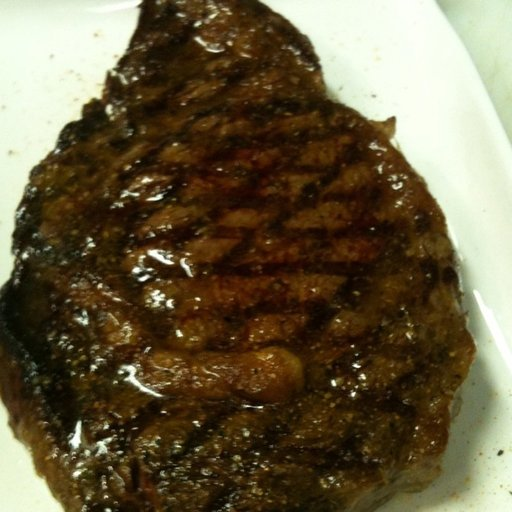

In [ ]:
image_list = list(image_path.glob('*/*/*.jpg'))
rand_image = random.choice(image_list)
image_class = rand_image.parent.stem
img = Image.open(rand_image)
print(f"Image Class: {image_class}")
img

In [ ]:
train_data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=8, num_steps=2),
    transforms.ToTensor()
])
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

TypeError: TrivialAugmentWide.__init__() got an unexpected keyword argument 'num_steps'

In [ ]:
def plot_transformed_images(transform, image_list):
  torch.manual_seed(42)
  sample_list = random.sample(image_list, 3)
  for image_path in sample_list:
    with Image.open(image_path) as f:
      fig ,ax = plt.subplots(1,2)
      image = transform(f).permute(1, 2, 0)
      ax[0].imshow(f)
      ax[1].imshow(image)
      ax[0].axis('off')
      ax[1].axis('off')
      plt.show()




In [ ]:
train_data = datasets.ImageFolder(root = train_path, transform = train_data_transform, target_transform = None)
test_data = datasets.ImageFolder(root = test_path, transform = data_transform)

In [ ]:
torch.manual_seed(42)
train_dataloader = DataLoader(train_data, batch_size = 32, shuffle = True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size = 32, shuffle = False)
train_img_data , train_label_data = next(iter(train_dataloader))
test_img_data, test_label_data = next(iter(test_dataloader))

NameError: name 'train_data' is not defined

In [ ]:
class image_model(nn.Module):
  def __init__(self, in_channels, out_channels,  hidden_channels):
    super().__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels, hidden_channels, kernel_size = 3,  stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(hidden_channels, hidden_channels, kernel_size = 3, stride = 1 , padding =1),
        nn.ReLU(),
        nn.MaxPool2d(stride = 2, kernel_size = 2)
    )

    self.block2 = nn.Sequential(
        nn.Conv2d(hidden_channels, hidden_channels, kernel_size = 3,  stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(hidden_channels, hidden_channels, kernel_size = 3, stride = 1 , padding =1),
        nn.ReLU(),
        nn.MaxPool2d(stride = 2, kernel_size = 2)
    )

    self.FC_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_channels*16*16, out_channels)
    )

  def forward(self, x):
      return self.FC_layer(self.block2(self.block1(x)))

def accuracy(y_pred, y):
  correct = torch.eq(y_pred,y).sum().item()
  return (correct/len(y))*100

model_0 = image_model(in_channels = 3, out_channels = len((train_data.classes)), hidden_channels = 10).to(device)

NameError: name 'train_data' is not defined

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr=0.001)

In [ ]:
def train_step(model, dataLoader, optimizer, loss_fn, accuracy):
  model.train()
  train_loss,train_acc =0,0
  for batch, (x,y) in enumerate(dataLoader):
    logits = model(x.to(device))
    y_pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)
    loss = loss_fn(logits, y.to(device))
    acc = accuracy(y_pred, y.to(device))
    train_loss+=loss
    train_acc += acc
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss / len(dataLoader)
  train_acc = train_acc / len(dataLoader)
  return train_loss, train_acc

def test_step(model, dataLoader, optimizer, loss_fn, accuracy):
  model.eval()
  test_loss, test_acc = 0,0
  for batch, (x,y) in enumerate(dataLoader):
    logits = model(x.to(device))
    y_pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)
    loss = loss_fn(logits, y.to(device))
    acc = accuracy(y_pred, y.to(device))
    test_loss += loss
    test_acc += acc
  test_loss = test_loss/len(dataLoader)
  test_acc = test_acc/len(dataLoader)
  return test_loss, test_acc

In [ ]:
def train(train_step, test_step, model, epochs, optimizer, loss_fn, accuracy):
  for epoch in range(epochs):
    train_loss, train_acc = train_step(model, train_dataloader, optimizer, loss_fn, accuracy)
    test_loss, test_acc = test_step(model, test_dataloader, optimizer, loss_fn, accuracy)
    if( epoch % 10 == 0):
      print(f"Epoch: {epoch} Train Loss: {train_loss} Train Accuracy: {train_acc} Test Loss: {test_loss} Test Accuracy: {test_acc}")
    if(epoch == epochs-1):
      plot_loss_curves(train_loss,train_acc, test_loss, test_acc, epochs)

In [ ]:
epochs = 101
train(train_step,test_step, model_0,epochs, optimizer, loss_fn, accuracy)

NameError: name 'model_0' is not defined

In [ ]:
def plot_loss_curves(train_loss,train_acc, test_loss, test_acc,epochs):
  plt.figure(figsize=(12,8))
  plt.plot(epochs,)
